In [1]:
import tensorflow as tf
tf.__version__

'2.8.0'

## 데이터 로드

In [2]:
import os, shutil
import matplotlib
import matplotlib.pyplot as plt
from os import remove
import numpy as np
import glob
import PIL
from PIL import Image

In [3]:
# ## 파일 확장자명 jpg로 통일
# list_f = ['train_gochu', 'train_hobak', 'train_oe', 'train_ohobak']
# list_i = ['jpeg', 'JPEG', 'JPG']
# path = './datasets/Plant_diseases/Diseases/'

# # for x in list_f:
# #   path_ = (f'{path}/{x}')
# for i in list_i:
#   files = glob.glob(f'/content/drive/MyDrive/Colab/img/*/*.{i}')
#   for name in files:
#     if not os.path.isdir(name):
#       src = os.path.splitext(name)
#       os.rename(name, src[0]+'.jpg')

### 이미지, 라벨링 파일 전체 불러오기
- 파일 전처리 (잎 부위촬영 제외 모두 삭제)
- 숨김 파일 제외
- ???_과제번호(79)_질병 (0/1)_질병코드_작물코드_촬영부위코드(잎 03)_작물생육코드_해충피해코드(정상0 초기1 중기2 말기3)
- 질병코드 :
    - 정상 00

    - 고추 탄저병 01. => 작물코드 ( 01 )

    - 고추 흰가루병 02  => 작물코드 ( 01 )
    - 애호박 흰가루병 08 => 작물코드 ( 04 )
    - 오이 흰가루병 12 => 작물코드 ( 06 )
    - 호박 흰가루병 20 => 작물코드 ( 10 )

In [4]:
# os.path.basename(파일경로)

In [5]:
# ## 숨긴파일, 라벨 파일 제외하고 불러오기
# def load_image_path(path):
#     file_list = os.listdir(path)
#     print(file_list)
#     file_list_py = [file for file in file_list if not file.startswith('.')]
#     return file_list_py

In [6]:
# for x in list_f:
#   path_ = (f'{path}/{x}')
#   img = load_image_path(path_)
#   print(img)

In [7]:
# # 촬영부위가 잎이 아닌 이미지 모두 삭제
# def leaf_img(datas): 
#     ls = []
#     for data in datas:
#         if data.split('_')[5] != '03':
#             ls.append(data)
#     new_datas = [x for x in datas if x not in ls]
#     return new_datas

In [8]:
# leaf = leaf_img(img)
# leaf

In [9]:
# ## 흰가루병이 아닌 이미지 모두 삭제 
# ## 정상에서는 사용하지 말것
# ## 질병코드(index 3): 고추 02, 애호박 08, 오이 12, 호박 20
# ## 작물코드(index 4): 고추 01, 애호박 04, 오이 06, 호박 10

# def disease_code(datas): 
#     new_datas = []
#     for data in datas:
#         crops = data.split('_')[4]
#         disease = data.split('_')[3]
        
#         if crops == '01' and disease == '02': # 고추흰가루병
#             new_datas.append(data) 
            
#         elif crops == '04' and disease == '08': # 애호박 흰가루병
#             new_datas.append(data) 
                
#         elif crops == '06' and disease == '12': # 오이 흰가루병
#             new_datas.append(data)  
                
#         elif crops == '10' and disease == '20':  # 호박 흰가루병
#             new_datas.append(data) 
#     return new_datas

In [10]:
# root_path = './datasets/Plant_diseases/Diseases' ## root path
# # os.mkdir(root_path)

# train_dir = root_path + '/train'
# # os.mkdir(train_dir)

# valid_dir = root_path + '/valid'
# # os.mkdir(valid_dir)

# test_dir = root_path + '/test'
# # os.mkdir(test_dir)

In [11]:
path = '/Volumes/One Touch/plantDatasets_fix_PILError/'
# file_list = os.listdir(path)

## root path
image_dir = os.path.join(path,'Plant_diseases/Diseases')  

## train path
train_dir = os.path.join(image_dir,'train') 

## valid path
valid_dir = os.path.join(image_dir,'valid') 

## test path
test_dir = os.path.join(image_dir,'test') 

In [12]:
# ## opencv로 불러와서 다시 저장하기
# import cv2
# import PIL, glob
# from tqdm import tqdm ## for문에서 걸리는 시간 보여주는 라이브러리

# imgs_ = glob.glob(f"./datasets/Plant_diseases/Diseases/*/*/*")

# for img in tqdm(imgs_):
#     try:
#         src = cv2.imread(img, cv2.IMREAD_UNCHANGED)
#         cv2.imwrite(img, src)

#     except PIL.UnidentifiedImageError:
#         print(img)
#         cv2.imwrite(img, src)

In [13]:
# 안열리는 파일 삭제 
import PIL, glob
from PIL import Image
from os import remove

datalist = ['train', 'test', 'valid']

for data in datalist : 
    imgs_ = glob.glob(f"./datasets/Plant_diseases/Diseases/{data}/*/*.jpg")

    for img in imgs_:
        try:
            img = PIL.Image.open(img)
        except PIL.UnidentifiedImageError:
            print(img)
            remove(img)

In [14]:
# # imgs_에 있는 것들의 이미지만 가져옴
# l = []
# for i in range(len(imgs_)):
#     x = os.path.basename(imgs_[i])
#     l.append(x)
# print(l)

## 현재 l이 사진들 이름

## 모델

In [15]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras import layers, models

In [16]:
# 사전학습된 VGG16 모델 불러오기
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape=(224, 224, 3))

# weights : 가중치 모델 지정 ( None : 초기화된 가중치, 'imagenet' : 사전 학습된 가중치 )
# include_top : 네트워크의 최상위 완전 연결 분류기(fc)를 포함할지 안할지 지정
#               별도로 식물을 구분하는 완전 연결 층을 추가하려고 하므로, 이를 포함하지 않음 (False)
# input_tensor : 입력 텐서 크기 ( Input(shape = (넓이, 높이, 채널)) - 지정하지 않으면 어떤 크기의 입력도 처리 가능
# input_shape : 앞에 2개 숫자는 가로, 세로를 가리키며, 마지막 숫자인 3은 R,G,B 3개를 의미한다.
base_model.summary()   # 최종 특성 맵의 크기 (7, 7, 512)

Metal device set to: Apple M1


2022-05-01 17:26:54.791219: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-01 17:26:54.791316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
# 모델 Layer 데이터화
layer_dict = dict([(layer.name, layer) for layer in base_model.layers])

# Layer 추가
x = layer_dict['block5_pool'].output

x = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)   # Softmax 함수로 5개 분류

# new model 정의
new_model = Model(inputs=base_model.input, outputs=x)

In [18]:
# Convolution Layer를 학습되지 않도록 고정
# 새롭게 추가된 층 이외의 VGG16의 19번째 레이어까지 학습하지 않고 고정
for layer in base_model.layers[:19]:
    layer.trainable = False

new_model.summary()

# 모델 컴파일
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
from keras.preprocessing.image import ImageDataGenerator
# 사용하는 이유 : 별도의 파일을 안 만들고, 위처럼 폴더의 이름 자체를 label 하는 방법을 이제부터 할 예정이다. 즉 train안에 폴더 3개를 보고 각각 분류가 됐다는 걸 알 수 있다. 
#                 label의 정보를 주는 방법 중 하나라고 생각하면 될 것이다. 이 폴더를 학습을 시키면 labeling 없이 학습이 된다.

# train_dir, validation_dir은 위에서 정의하기
batch_size = 20
image_size = 224

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # 회전 최대 20도
    width_shift_range=0.2, # 좌우 이동
    height_shift_range=0.2, # 상하 이동
    horizontal_flip=True, # 좌우 반전
    vertical_flip=True, # 상하 반전
    fill_mode='nearest' # 인풋 경계의 바깥 공간은 다음의 모드에 따라 다르게 채운다.
    )
 
# 검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator(rescale=1./255)


# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

# 검증에 사용될 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
        valid_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)



class_num=len(train_generator.class_indices)

custom_labels = list(validation_generator.class_indices.keys())

Found 15065 images belonging to 2 classes.
Found 3767 images belonging to 2 classes.


fill_mode: {"constant", "nearest", "reflect" 혹은 "wrap"} 중 하나. 디폴트 값은 'nearest'입니다. 인풋 경계의 바깥 공간은 다음의 모드에 따라 다르게 채워집니다:

* 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
* 'nearest': aaaaaaaa|abcd|dddddddd
* 'reflect': abcddcba|abcd|dcbaabcd
* 'wrap': abcdabcd|abcd|abcdabcd

In [20]:
# 모델 학습 전에 한번만 실행
steps_epoch = len(train_generator)//batch_size
print(steps_epoch)

valid_steps = len(validation_generator)//batch_size
print(valid_steps)

37
9


In [21]:
# 모델 학습

# Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50 batches)
# You may need to use the repeat() function when building your dataset.
# 오류나서 steps_per_epoch와 epochs를 곱한 것이 train_generator 값보다 작게 바꿈 (각각 96, 20)
# steps_per_epoch와 validation_steps를 위에서 계산

history = new_model.fit(train_generator,
                        steps_per_epoch = steps_epoch,
                        epochs = 20,
                        validation_data = validation_generator)

Epoch 1/20


2022-05-01 17:26:58.363377: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-01 17:26:58.736548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - ETA: 0s - loss: 0.4707 - accuracy: 0.8932

2022-05-01 17:28:34.802457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 470s 13s/step - loss: 0.4707 - accuracy: 0.8932 - val_loss: 0.2793 - val_accuracy: 0.9036
Epoch 2/20
37/37 [==============================] - 488s 13s/step - loss: 0.2934 - accuracy: 0.9007 - val_loss: 0.2217 - val_accuracy: 0.9036
Epoch 3/20
37/37 [==============================] - 491s 14s/step - loss: 0.2676 - accuracy: 0.8973 - val_loss: 0.2444 - val_accuracy: 0.9036
Epoch 4/20
37/37 [==============================] - 491s 14s/step - loss: 0.2194 - accuracy: 0.9257 - val_loss: 0.2590 - val_accuracy: 0.9036
Epoch 5/20
37/37 [==============================] - 490s 14s/step - loss: 0.2403 - accuracy: 0.9068 - val_loss: 0.1924 - val_accuracy: 0.9036
Epoch 6/20
37/37 [==============================] - 489s 13s/step - loss: 0.2252 - accuracy: 0.9108 - val_loss: 0.2013 - val_accuracy: 0.9036
Epoch 7/20
37/37 [==============================] - 492s 14s/step - loss: 0.2009 - accuracy: 0.9149 - val_loss: 0.1894 - val_accuracy: 0.9036
Epoch 8/20
37/37 

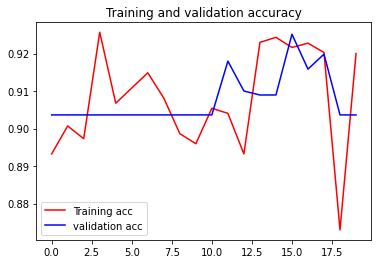

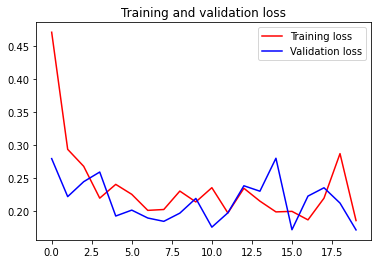

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
test_generator = validation_datagen.flow_from_directory(test_dir,
                                                  target_size = (224, 224),
                                                  batch_size = 20,
                                                  class_mode = 'categorical')

test_loss, test_acc = new_model.evaluate_generator(test_generator,steps=48)
print(f'test loss: {test_loss}, test acc: {test_acc}')

Found 4709 images belonging to 2 classes.


/var/folders/n_/n7h63p7n0p94s4q0cjjkgtl40000gn/T/ipykernel_8671/1716609803.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = new_model.evaluate_generator(test_generator,steps=48)


test loss: 0.1654856950044632, test acc: 0.9041666984558105


In [27]:
# 모델 저장
# import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2

saved_model_dir = './VGG16_0501.h5'

new_model.save(saved_model_dir)